In [1]:
import xarray as xr
#import netCDF4
import json
import pandas as pd
import numpy as np
import pytz
import pyproj

from datetime import datetime, timedelta

from dispel4py.workflow_graph import WorkflowGraph 
from dispel4py.provenance import *

from dispel4py.base import create_iterative_chain, ConsumerPE, IterativePE, SimpleFunctionPE

In [2]:
class ReadCSV(GenericPE):
    
    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('input')
        self._add_output('csv_output')
        self._add_output('csv_file')
    
    def _process(self,inputs):
        self.log('Reading CSV')
        csvFile = inputs['input'][0]
        csvMeta = inputs['csv_desc'][0]
        
        headerText = self.readHeaderLines(csvFile)
        
        self.invalidDateTime = np.datetime64('4000-01-01')
        
        # TODO: if needed port the json handling method
        self.metaCSVdict = self.readJson(csvMeta)
        delimiter = self.metaCSVdict['csvSeparator']
        columnsList = []
        columnsList.append(self.metaCSVdict['columnDate'])
        columnsList.append(self.metaCSVdict['columnHour'])
        columnsList.append(self.metaCSVdict['columnMinute'])
        columnsList.append(self.metaCSVdict['columnX'])
        columnsList.append(self.metaCSVdict['columnY'])        
        
        
        self.dataUnsortedStr = np.recfromtxt(csvFile, skip_header=self.numHeaderLines, comments="#", dtype="|S300", delimiter=delimiter)
        self.dataColumns = self.dataUnsortedStr[:, columnsList ]
        
        rowCounter = 0
        queryDataArray = []        
        for oneRow in self.dataColumns:
            (utcTimeStr, utcTime) = self.decodeDateTime(dateStr=oneRow[0], hourStr=oneRow[1], minuteStr=oneRow[2])
            if utcTimeStr==None:  # None means INVALID request!
                dataRow = [rowCounter, self.invalidDateTime, "INVALID", float(oneRow[3]), float(oneRow[4])]
                # store [id, utc-time, utc-time-str, X-coord, Y-coord ]
                queryDataArray.append(dataRow)
            else:
                dataRow = [rowCounter, np.datetime64(utcTime), utcTimeStr, float(oneRow[3]), float(oneRow[4])]
                # store [id, utc-time, utc-time-str, X-coord, Y-coord ]
                queryDataArray.append(dataRow)
            rowCounter += 1
            
        # Translate the python list to a 2 dimensional numpy array of [ [id, utc-time, X-coord, Y-coord], ... ]
        queryDataNPA = np.array(queryDataArray)

        self.timeUnits = ""  # self.metaData.variables['time'].units
        self.dateTimeArray = queryDataNPA[:, 1]
        
        # remove invalid dateTime records from the array
        indexDelete = np.where(self.dateTimeArray == self.invalidDateTime)  # reserved  for "INVALID"
        self.dateTimeArrayClean = np.delete(self.dateTimeArray, indexDelete)
        
        # np.datetime64 => datetime; The date-time must be in UTC
        self.minDateTime = np.min(self.dateTimeArrayClean).astype(datetime.datetime).replace(tzinfo=pytz.UTC)
        self.maxDateTime = np.max(self.dateTimeArrayClean).astype(datetime.datetime).replace(tzinfo=pytz.UTC)

        fmt = '%Y-%m-%d %H:%M:%S %Z'
        self.minDateTime_str = self.minDateTime.strftime(fmt) 
        self.maxDateTime_str = self.maxDateTime.strftime(fmt)

        queryDataNPAdt = queryDataNPA  # create sorted 2-dimensional array
        self.queryDataNPAdt = queryDataNPAdt
        
        self.projFuncDefstring = self.metaCSVdict['projString']
        self.projectionFunction = pyproj.Proj(self.projFuncDefstring)
        
        # 2-dimensional numpy array [  [id, utc-time, X-coord, Y-coord ], .. ] sorted by utc time
        xcoords = queryDataNPAdt[:, 3]  # still a 1-dimensional numpy array of strings
        ycoords = queryDataNPAdt[:, 4]  # still a 1-dimensional numpy array of strings
        
        (longitudes,latitudes) = self.unproject2LongitudeLatitudes(xcoords, ycoords)
        lonLatStacked = np.vstack((longitudes,latitudes)).T
        # print lonLatStacked

        # Determine the bounding box.
        self.llbox_west = np.min(longitudes)
        self.llbox_east = np.max(longitudes)
        self.llbox_north = np.max(latitudes)
        self.llbox_south = np.min(latitudes)
    
        self.queryDataNPAdtsLL = np.vstack((queryDataNPAdt[:, 0], queryDataNPAdt[:, 1], longitudes, latitudes)).T
        
        # self.log(self.queryDataNPAdtsLL)

        self.write('csv_file', csvFile)
        self.write('csv_output', self.queryDataNPAdtsLL)
        
    
    def readHeaderLines(self, fileName):
        self.numHeaderLines = 1
        headerText = ""
        n = self.numHeaderLines
        ftxt = open(fileName,'rU')
        while n>0:
            ln = ftxt.readline()
            if not ln:
                break
            headerText += ln.rstrip('\n')  
            n -= 1
        ftxt.close()
        return headerText
    
    def readJson(self, fileName):
        with open(fileName) as json_file:  
            data = json.load(json_file)
        return data
    
    def decodeDateTime(self, dateStr, hourStr, minuteStr):

        if self.metaCSVdict['dateFormat'] == "%d%b%y":
            givenDate = datetime.datetime.strptime(dateStr, "%d%b%y")
            
        if self.metaCSVdict['hourFormat'] == "hourInterval":
            try:
                if '-' in hourStr:
                    hour = float(hourStr.split('-')[0])
                else:
                    hour = float(hourStr[:3])
            except:
                if self.autoResolve_hour>0:
                    hour = self.autoResolve_hour
                else:
                    try:
                        minute = int(minuteStr)
                        self.log('WARNING: could not extract (hour) from: "(%s)"' %(hourStr) )
                    except:
                        self.log('WARNING: could not extract (hour & minute) from: "(%s,%s)"' %(hourStr, minuteStr))
                    
                    return None,None  # this mean INVALID request

            try:
                minute = int(minuteStr)
            except:
                if self.autoResolve_minute>0:
                    minute = self.autoResolve_minute
                else:
                    self.log('WARNING: could not extract minute from: "%s"' %(minuteStr) )
                    return None, None  # this mean INVALID request

            
        localTime = givenDate + timedelta(hours=hour, minutes=minute)
        
        (utcTime, datetime_in_utc_str, datetime_with_tz_str) = self.convertLocalDateTime2Utc(localTime, zone=self.metaCSVdict['timeZone'])
        
        fmt = '%Y-%m-%d %H:%M:%S %Z'
        utcTimeStr = utcTime.strftime(fmt)
        return (utcTimeStr, utcTime)
        
    def convertLocalDateTime2Utc(self,datetime_without_tz, zone):
        fmt = '%Y-%m-%d %H:%M:%S %Z (%z)'
       
        local_tz = pytz.timezone(zone)

        needToDecide = False
        try:
            datetime_with_tz = local_tz.localize(datetime_without_tz, is_dst=None)  # No daylight saving time
        except pytz.exceptions.AmbiguousTimeError:
            needToDecide = True
        except pytz.exceptions.NonExistentTimeError:
            needToDecide = True
        if needToDecide:
            datetime_with_tz = local_tz.localize(datetime_without_tz, is_dst=False)
        
        datetime_in_utc = datetime_with_tz.astimezone(pytz.utc)

        datetime_with_tz_str = datetime_with_tz.strftime(fmt)
        datetime_in_utc_str = datetime_in_utc.strftime(fmt)

        return (datetime_in_utc, datetime_in_utc_str, datetime_with_tz_str)
    
    def unproject2LongitudeLatitudes(self, xcoords, ycoords):
        LL  = self.projectionFunction(xcoords, ycoords, inverse=True)
        longitudes = LL[0]
        latitudes = LL[1]
        return (longitudes, latitudes)  # tuple, vector
        


In [3]:
class ReadNETCDF(GenericPE):
    
    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('input')
        self._add_output('netcdf_out')
    
    def _process(self,inputs):
        self.log('Reading NetCDF')
        netcdfFile = inputs['input'][0]
        fmt = '%Y-%m-%d %H:%M:%S %Z'
        
        #open NetCDF dataset with xarray
        ds = xr.open_dataset(netcdfFile)
        
        #Time variables
        dt = ds['time'] #date-time DataArray
        timeDim = dt.shape[0]
         
        minDateTimeArray = np.min(dt) #returns minDate in a DataArray
        maxDateTimeArray = np.max(dt)
        minDateTime = minDateTimeArray.values #gets the value out of the DataArray
        maxDateTime = maxDateTimeArray.values
        
        minDateTime_conv = pd.to_datetime(minDateTime) #converts numpy datetime64 to datetime (better for readability)
        # minDataTime_str = minDateTime_conv.strftime(fmt)
        maxDateTime_conv = pd.to_datetime(maxDateTime)
        # maxDataTime_str = maxDateTime_conv.strftime(fmt)
        
        
        timeDelta = np.timedelta64(dt[1].values - dt[0].values, 'm') #time delta between consecutive measurements in minutes
        
        #Spatial variables
        dx = ds['x']
        dy = ds['y']
        xDim = dx.shape[0]
        yDim = dy.shape[0]
        gridSize = xDim * yDim
        
        xAxis = dx.data[:]
        yAxis = dy.data[:]
        
        self.xcoords, self.ycoords  = np.meshgrid(xAxis, yAxis)
        
        self.projFuncDefstring = ds['projection'].proj4_params
        self.projectionFunction = pyproj.Proj(self.projFuncDefstring)
        
        (self.longitudes,self.latitudes) = self.unproject2LongitudeLatitudes(self.xcoords, self.ycoords)
        self.lonLatStacked = np.hstack((self.longitudes.reshape(gridSize,1),self.latitudes.reshape(gridSize,1)))
        
        self.llbox_west = np.min(self.longitudes)
        self.llbox_east = np.max(self.longitudes)
        self.llbox_north = np.max(self.latitudes)
        self.llbox_south = np.min(self.latitudes)
        
        ds.__setitem__('lonLatStacked', (['locations', 'coordinates'], self.lonLatStacked))

        self.write('netcdf_out', ds)
        

        
    def unproject2LongitudeLatitudes(self, xcoords, ycoords):
        LL = self.projectionFunction(xcoords, ycoords, inverse=True)
        longitudes = LL[0]
        latitudes = LL[1]
        return (longitudes, latitudes) # tuple, vector

In [4]:
class ProcessData(GenericPE):
    
    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('csvData', grouping=[1])
        self._add_input('netcdfData', grouping=[1])
        self._add_output('output')
        self.csv=[]
        self.netcdf=[]
 
    
    def _process(self,inputs):
        self.log('Processing Data')
        
        #function used for getting the distance between 2 points
        geoTransfWGS84 = pyproj.Geod(ellps='WGS84')
        self.geoTransf = geoTransfWGS84
        
        if 'csvData' in inputs.keys():
            self.csv.append(inputs['csvData'])
        
        if 'netcdfData' in inputs.keys():
            self.netcdf.append(inputs['netcdfData'])
        
        if (len(self.csv)>0 and len(self.netcdf)>0):
            self.csvData = self.csv.pop(0)
            self.netcdfData = self.netcdf.pop(0)
            
            self.dateTimeArray = self.netcdfData['time'].values
            
            dx = self.netcdfData['x']
            self.xDim = dx.shape[0]

            variableName = 'precipitation_amount'
            valueList = []

            for timeLonLat in self.csvData:
                idn = timeLonLat[0]
                utcTime = timeLonLat[1]
                lon = timeLonLat[2]
                lat = timeLonLat[3]
                value = self.GetValue_time_lon_lat(variableName, utcTime, lon, lat)
                valueList.append(value)
            valueArray = np.array(valueList)

            processedData = np.hstack((self.csvData, valueArray.reshape(valueArray.shape[0], 1)))

            self.write('output', processedData)
        

        
    def GetValue_time_lon_lat(self, variableName, utcTime, lon, lat):
        
        closestDateTimeIndex = self.FindClosestDateTimeIndex(utcTime)
        minDistanceDataIndex = self.FindClosestLonLatPointIndex(lon, lat)
        dataValue = self.GetDataAtIndex(closestDateTimeIndex, minDistanceDataIndex, variableName=variableName)

        return dataValue
    
    
    def FindClosestDateTimeIndex(self, time):
        closestTime = self.FindClosestDateTime(time, self.dateTimeArray)
        closestTimeIndex = np.where(self.dateTimeArray == closestTime)[0][0]
        return closestTimeIndex
    
    def FindClosestDateTime(self, givenDateTime, dateTimeList):
        pivot = np.datetime64(givenDateTime)
        result = min(dateTimeList, key=lambda x: abs(x - pivot))
        return result
    
    def FindClosestLonLatPointIndex(self, lon, lat):
        self.givenLon = lon
        self.givenLat = lat
    
        idx = 0
        distArray = np.zeros(self.netcdfData['lonLatStacked'].shape[0])
        coordinatesArray = self.netcdfData['lonLatStacked'].values
        for tupleLL in coordinatesArray:
            dist = self.Distance2pointsInLonLat(lon, lat, tupleLL[0], tupleLL[1])
            distArray[idx] = dist
            idx +=1
        minDist = np.min(distArray)
        minDistIndex = np.where(distArray == minDist)[0][0]
        return minDistIndex
    
    def Distance2pointsInLonLat(self, lng1,lat1,lng2,lat2):
        #global geoTransfWGS84
        #geoTransfWGS84
        az12,az21,dist = self.geoTransf.inv(lng1,lat1,lng2,lat2)
        return dist
        
    def GetDataAtIndex(self, timeIndex, dataIndex, variableName='precipitation_amount'):
        idX = dataIndex % self.xDim
        idY = dataIndex / self.xDim

        # variableFound = self.GetVariable(variableName)
        # if variableFound:
        #     dataValue = variableFound[timeIndex][idY][idX]
        #     return dataValue
        # else:
        #     return None

        # 'image1_image_data' holds the 'precipitation_amount' data
        valueDataArray = self.netcdfData['image1_image_data'][timeIndex][idY][idX]
        dataValue = valueDataArray.values.item(0)
        return dataValue
    
    
    #needs to be adapted to xarray
    def GetVariable(self, variableName):
        keylist = self.metaData.variables.keys()
        variableFound = None
        for k in keylist:
            try:
                if self.metaData.variables[k].standard_name == variableName:
                    #  self.metaData.variables['image1_image_data'].standard_name == variableName ..
                    variableFound = self.metaData.variables[k]
            except:
                pass
        return variableFound


In [5]:
class StoreData(GenericPE):
    
    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('wrangler_output')
        self._add_input('csv_file')
        self.csv = False
        self.wrangler = False
         
        
    def _process(self,inputs):
        self.log('Storing Data')
        outputLocation = "output/wrangled_data.csv"
        parameterList = ["utc-time", "longitude", "latitude", "precipitation_amount"]

        if 'csv_file' in inputs.keys():
            csvFile = inputs['csv_file']
            self.csvHeader = self.readHeaderLines(csvFile)
            self.csvContent = np.recfromtxt(csvFile, skip_header=1, comments="#", dtype="|S300", delimiter=',')
            self.csv = True

        if 'wrangler_output' in inputs.keys():
            self.wranglerResults = inputs['wrangler_output']
            self.wrangler = True

        if self.csv and self.wrangler:

            for item in parameterList:
                self.csvHeader += ',%s' %item

            finalStack = np.hstack((self.csvContent, self.wranglerResults[:,1:]))

            np.savetxt(outputLocation, finalStack, fmt='%s', delimiter=',', header=self.csvHeader)


    def readHeaderLines(self, fileName):
        self.numHeaderLines = 1
        headerText = ""
        n = self.numHeaderLines
        ftxt = open(fileName, 'rU')
        while n > 0:
            ln = ftxt.readline()
            if not ln:
                break
            headerText += ln.rstrip('\n')
            n -= 1
        ftxt.close()
        return headerText

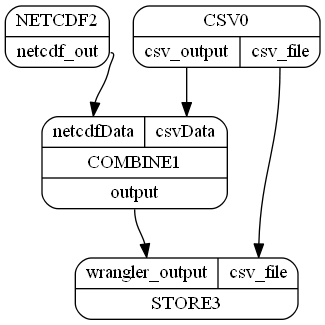

In [6]:
def createWorkflow():
    read_csv = ReadCSV()
    read_csv.name = 'CSV'
    read_netcdf = ReadNETCDF()
    read_netcdf.name = 'NETCDF'
    compute = ProcessData()
    compute.name = 'COMBINE'
    store = StoreData()
    store.name = 'STORE'
    
    graph = WorkflowGraph()
    graph.connect(read_csv, 'csv_output', compute, 'csvData')
    graph.connect(read_netcdf, 'netcdf_out', compute, 'netcdfData')
    graph.connect(read_csv, 'csv_file', store, 'csv_file')
    graph.connect(compute, 'output', store, 'wrangler_output')
    
    return graph


workflow_graph = createWorkflow()

from dispel4py.visualisation import display
display(workflow_graph)

In [7]:
input_data = {     
                'CSV': [{ 'input': [ 'data/accident_data.csv'], 'csv_desc': ['data/metaDataCsv.json'] }],
                'NETCDF': [{ 'input': ['http://opendap.knmi.nl/knmi/thredds/dodsC/DATALAB/hackathon/radarFull2006.nc'] }]
                #'NETCDF': [ { 'input': [ 'data/radarFull2006.nc'] }] too large for GitHub
             }

In [8]:
class netcdfProvType(ProvenanceType):
    def __init__(self):
        ProvenanceType.__init__(self)
        self.addNamespacePrefix("clipc","http://clipc.eu/ns/#")
    
    def extractDataSourceId(self,data, input_port):
        #Extract here the id from the data (type specific):
        try:
             
            ds = xarray.open_dataset(data[0])
            id = ds.attrs['id']
             
             
        except Exception, err:
            id = str(uuid.uuid1())
             
        return id
     
    
    def makeUniqueId(self, data, output_port):      
        
        
        #produce the id
        id=str(uuid.uuid1())
            
        if data!=None:
            xa = data[0]
        
            xa.attrs['id'] = id
        
        #Return
        return id 
    

    
    ''' extracts xarray metadata '''
    def extractItemMetadata(self, data, output_port):
         
        
        try:            
            nc_meta = OrderedDict()
            
            ''' cycle throug all attributes, dimensions and variables '''
            xa = data[0]
            # dataset meta
            nc_meta['Dimensions'] = str( dict(xa.dims)) 
            nc_meta['Type'] = str(type(xa))
            
             
            for n , i in xa.data_vars.items():
                for k , v in i.attrs.items():
                    nc_meta['clipc:'+n+"_"+str(k).replace(".","_")] = str(v)[0:25]
            
           
            metadata = [nc_meta]
            
            return metadata
                             
        except Exception, err:
            self.log("Applying default metadata extraction"+str(traceback.format_exc()))
            self.error=self.error+"Applying default metadata extraction:"+str(traceback.format_exc())
            return super(netcdfProvType, self).extractItemMetadata(data,output_port);
        
        
        
class Nby1Flow(ProvenanceType):
    def __init__(self):
        ProvenanceType.__init__(self)
        self.ports_lookups={}
        

    def apply_derivation_rule(self,event,voidInvocation,oport=None,data=None,iport=None,metadata=None):
    
         

        if (event=='write'):
            dep=[]
            for x in self.inputconnections:
                if x!=iport and x!='_d4py_feedback':
                    vv=self.ports_lookups[x].pop(0)
                    dep.append(vv)
                    #self.log("LOOKUP: "+str(vv))
                self.setStateDerivations(dep)
                

        if (event=='end_invocation_event' and voidInvocation==True):
                
            if data!=None:
                #self.ports_lookups['iport'].append(vv)
                vv=str(abs(make_hash(tuple(iport+str(self.iterationIndex)))))
                if not (iport in self.ports_lookups):
                    self.ports_lookups[iport]=[]

                self.ports_lookups[iport].append(vv)
                #self.log(self.ports_lookups)
                #self.ignorePastFlow()
                self.update_prov_state(vv,None,metadata={"LOOKUP":str(vv)})
                self.discardInFlow()


        if (event=='end_invocation_event' and voidInvocation==False):
                 self.discardInFlow()
                 self.discardState()
                    
class CsvFlow(ProvenanceType):
    def __init__(self):
        ProvenanceType.__init__(self)
    
    def extractCsvMeta(self,data, input_port):
    
        try:        

            headerText = self.readHeaderLines(data[0])

        except Exception, err:

            headerText = 'No data'

        return headerText

In [9]:
prov_config =  {
                    'provone:User': "afrunze", 
                    's-prov:description' : "wrangler provenance",
                    's-prov:workflowName': "wrangler",
                    's-prov:workflowType': "clipc:combine",
                    's-prov:workflowId'  : "workflow process",
                    's-prov:save-mode'   : 'service',
                    's-prov:componentsType' : 
                                       {'CSV':     {'s-prov:type':(CsvFlow,), 
                                                    's-prov:prov-cluster':'clipc:DataHandler'},
                                        'NETCDF':  {'s-prov:type':(netcdfProvType,),
                                                    's-prov:prov-cluster':'clipc:DataHandler'},
                                        'COMBINE': {'s-prov:type':(netcdfProvType, Nby1Flow,),
                                                    's-prov:prov-cluster':'clipc:Combiner'},
                                        'STORE':   {'s-prov:prov-cluster':'clipc:DataHandler'}
                                        },
                    's-prov:sel-rules': None
                }

In [10]:
#Store via service
ProvenanceType.REPOS_URL='http://127.0.0.1:8082/workflowexecutions/insert'
ProvenanceType.PROV_EXPORT_URL='http://127.0.0.1:8082/data/'

#Size of the provenance bulk before sent to storage or sensor
ProvenanceType.BULK_SIZE=3

In [11]:
def createWorkflowWithProv():
    
    graph=createWorkflow()

    # Ranomdly generated unique identifier for the current run
    rid='WRANGLER_'+getUniqueId()
    
    # Initialise provenance storage to service:
    configure_prov_run(graph, 
                     provImpClass=(ProvenanceType,),
                     username=prov_config['provone:User'],
                     runId=rid,
                     description=prov_config['s-prov:description'],
                     workflowName=prov_config['s-prov:workflowName'],
                     workflowType=prov_config['s-prov:workflowType'],
                     workflowId=prov_config['s-prov:workflowId'],
                     save_mode=prov_config['s-prov:save-mode'],
                     componentsType=prov_config['s-prov:componentsType']
                      
                    )
    
    return graph


workflow_graph = createWorkflowWithProv()

Change grouping implementation 
COMBINE Original base class: (<class 'dispel4py.core.GenericPE'>,)
 New type: (<class '__main__.netcdfProvType'>, <class '__main__.Nby1Flow'>, <class '__main__.ProcessData'>)
CSV Original base class: (<class 'dispel4py.core.GenericPE'>,)
 New type: (<class '__main__.CsvFlow'>, <class '__main__.ReadCSV'>)
NETCDF Original base class: (<class 'dispel4py.core.GenericPE'>,)
 New type: (<class '__main__.netcdfProvType'>, <class '__main__.ReadNETCDF'>)
STORE Original base class: (<class 'dispel4py.core.GenericPE'>,)
 New type: (<class 'dispel4py.provenance.ProvenanceType'>, <class '__main__.StoreData'>)
Inputs: {'NewWorkflowRun': [{'input': 'None'}]}
NewWorkflowRun8: BUILDING INITIAL DERIVATION
NewWorkflowRun8: STORING WORKFLOW RUN METADATA


error: [Errno 10061] No connection could be made because the target machine actively refused it

In [ ]:
def runWorkflow():
                                                     
    print input_data                   

    #Launch in simple process
    result = simple_process.process_and_return(workflow_graph, input_data)
    print "\n RESULT: "+str(result)


In [ ]:
runWorkflow()